In [23]:
import os
import shutil

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

In [25]:
class NaiveBayes:
    """
    Naive Bayes classifier for categorical data.
    """
    def __init__(self):
        """
        Initialize the NaiveBayes class with placeholder attributes.
        """
        self.features_prob_in_class_with_value = None
        self.classes_prob = None
        self.classes = None
        self.dataframe = None
        self.target = None
        self.feature_columns = None
    def fit(self, dataframe, target):
        """
        Fit the Naive Bayes model on the provided dataframe.
        Args:
            dataframe (pd.DataFrame): The data to fit the model.
            target (str): The name of the target column in the dataframe.
        """
        self.dataframe = dataframe
        self.target = target

        # Extract unique class labels from the target column
        self.classes = self.dataframe[self.target].unique()

        # Identify feature columns (all columns except the target)
        self.feature_columns = [col for col in dataframe.columns if col != self.target]

        # Calculate probability of each class
        self.classes_prob = self.__calc_classes_prob()

        # Calculate probability of each feature value given each class
        self.features_prob_in_class_with_value = self.__calc_features_prob_in_class_with_value()
    def predict(self, test_examples):
        """
        Predict the classes for the given test examples.
        Args:
            test_examples (np.ndarray): The test examples where each dict represents feature-value pairs.
        Returns:
            list: Predicted classes for the test examples.
        """
        # Transform test examples into a format suitable for prediction
        transformed_ex = self.__create_test_examples(test_examples)
        predictions = []

        # Predict class for each test example
        for ex in transformed_ex:
            prob = {}
            for cls in self.classes:
                cls_prob = self.classes_prob[cls]
                for feature, value in ex.items():
                    # Calculate the probability of the feature value given the class
                    if (feature in self.features_prob_in_class_with_value and
                            value in self.features_prob_in_class_with_value[feature]):
                        feature_in_class_prob = self.features_prob_in_class_with_value[feature][value].get(cls)
                        cls_prob *= feature_in_class_prob
                prob[cls] = cls_prob

            # Predict the class with the highest probability
            predicted_class = max(prob, key=prob.get)
            predictions.append(predicted_class)
        return predictions
    def __create_test_examples(self, test_array):
        """
        Convert test examples into a list of dictionaries.
        Args:
            test_array (np.ndarray): Array of test examples.
        Returns:
            list of dict: List of dictionaries where each dict represents feature-value pairs.
        """
        # Convert the test examples array into a DataFrame
        test_dataframe = pd.DataFrame(test_array, columns=self.feature_columns)

        # Convert test data rows into dictionaries with feature names as keys and feature values as values
        return [dict(zip(self.feature_columns, example)) for example in test_dataframe[self.feature_columns].values]
    def __calc_classes_prob(self):
        """
        Calculate the probability of each class based on their frequency in the training data.
        Returns:
            dict: Dictionary where keys are class labels and values are the probabilities.
        """
        prob = {}
        total_count = len(self.dataframe)  # Total number of samples

        # Calculate probability of each class
        for cls in self.classes:
            prob[cls] = len(self.dataframe[self.dataframe[self.target] == cls]) / total_count
        return prob
    def __calc_features_prob_in_class_with_value(self):
        """
        Calculate the probability of each feature value given each class.
        Returns:
            dict: Nested dictionary where the outer keys are feature names,
                  the inner keys are feature values, and the innermost keys are class labels.
        """
        prob = {}
        for feature in self.feature_columns:
            prob[feature] = {}
            for value in self.dataframe[feature].unique():
                prob[feature][value] = {}
                for cls in self.classes:
                    # Count occurrences of the feature value in the class
                    count_of_feature_in_class_with_value = len(
                        self.dataframe[(self.dataframe[self.target] == cls) & (self.dataframe[feature] == value)])
                    count_of_feature_in_class = len(self.dataframe[self.dataframe[self.target] == cls])
                    # Calculate conditional probability
                    prob[feature][value][cls] = count_of_feature_in_class_with_value / count_of_feature_in_class
        return prob

In [26]:
def separate_dataset(dataframe, target):
    """
    Separate the dataframe into features and target.
    Args:
        dataframe (pd.DataFrame): The dataframe to split.
        target (str): The name of the target column.
    Returns:
        tuple: A tuple containing features (X) and target (y).
    """
    # Drop the target column to get the feature columns
    x = dataframe.drop(columns=[target]).values
    y = dataframe[target].values
    return x, y

In [27]:
def visualize_categorical_data(dataframe, target_column='class', save_path='plots', show_plot=False, save_plots=True):
    """
    Visualize categorical data with count plots.
    Args:
        dataframe (pd.DataFrame): The dataframe containing the data.
        target_column (str): The name of the target column for hue in plots.
        save_path (str): Directory to save plots.
        show_plot (bool): Whether to display the plots.
        save_plots (bool): Whether to save the plots to files.
    """
    # Create the directory to save plots if it doesn't exist
    if save_plots:
        if os.path.exists(save_path):
            shutil.rmtree(save_path)  # Remove the directory if it already exists
        os.makedirs(save_path)  # Create the directory

    # Generate and save plots for each feature except the target column
    for i, col in enumerate(dataframe.columns):
        if col == target_column:
            continue  # Skip the target column
        plt.figure(figsize=(8, 6))
        sns.countplot(x=col, hue=target_column, data=dataframe)
        plt.title(col.replace('-', ' ').title())  # Title the plot with feature name
        plt.xlabel('Value')
        plt.ylabel('Count')
        plt.legend(title=target_column, loc='best')
        plt.tight_layout()  # Adjust layout to prevent overlap
        if save_plots:
            filename = f"{save_path}/{col.replace(' ', '_').replace('-', '_')}.png"
            plt.savefig(filename)  # Save the plot to file
            print(f"Plot saved at: {filename}")
        if show_plot:
            plt.show()  # Show the plot
        plt.close()  # Close the plot to free memory

Example Usage<br>
Uncomment and adjust the following sections based on the dataset you are using

Load dataset with appropriate columns and target feature<br>
Dataset: Agaricus Lepiota (Mushroom Classification)<br>
Columns include features related to mushroom characteristics and the target variable 'class' indicating the class of the mushroom.

In [28]:
# cols = [
#     'class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
#     'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
#     'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
#     'stalk-surface-below-ring', 'stalk-color-above-ring',
#     'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
#     'ring-type', 'spore-print-color', 'population', 'habitat'
# ]
# df = pd.read_csv('datasets/agaricus-lepiota.data', names=cols)
# target_feature = 'class'

Dataset: House Votes 1984<br>
Columns represent votes on various political issues and the target variable 'class' indicates the political party affiliation.

In [29]:
cols = [
    'class', 'handicapped-infants', 'water-project-cost-sharing',
    'adoption-of-the-budget-resolution', 'physician-fee-freeze',
    'el-salvador-aid', 'religious-groups-in-schools', 'anti-satellite-test-ban',
    'aid-to-nicaraguan-contras', 'mx-missile', 'immigration',
    'synfuels-corporation-cutback', 'education-spending', 'superfund-right-to-sue',
    'crime', 'duty-free-exports', 'export-administration-act-south-africa'
]
df = pd.read_csv('datasets/house-votes-84.data', names=cols)
target_feature = 'class'

Dataset: Connect-4 (Game Data)<br>
Columns represent various features of game positions in Connect-4, and the target variable 'class' indicates the game outcome.

In [30]:
# cols = [
#     'a1', 'a2', 'a3', 'a4', 'a5', 'a6',
#     'b1', 'b2', 'b3', 'b4', 'b5', 'b6',
#     'c1', 'c2', 'c3', 'c4', 'c5', 'c6',
#     'd1', 'd2', 'd3', 'd4', 'd5', 'd6',
#     'e1', 'e2', 'e3', 'e4', 'e5', 'e6',
#     'f1', 'f2', 'f3', 'f4', 'f5', 'f6',
#     'g1', 'g2', 'g3', 'g4', 'g5', 'g6',
#     'class'
# ]
# df = pd.read_csv('datasets/connect-4.data', names=cols)
# target_feature = 'class'

Dataset: Nursery (Educational Data)<br>
Columns represent various features related to nursery education and the target variable 'class' indicates the class of the nursery.

In [31]:
# cols = [
#     'parents', 'has_nurs', 'form', 'children', 'housing', 'finance', 'social', 'health', 'class'
# ]
# df = pd.read_csv('datasets/nursery.data', names=cols)
# target_feature = 'class'

Dataset: KR vs KP (Bank Marketing Data)<br>
Columns represent various features related to banking products and the target variable 'wtoeg' indicates a specific attribute related to customer behavior.

In [32]:
# cols = [
#     'bkblk', 'bknwy', 'bkon8', 'bkona', 'bkspr', 'bkxbq', 'bkxcr', 'bkxwp', 'blxwp', 'bxqsq',
#     'cntxt', 'dsopp', 'dwipd', 'hdchk', 'katri', 'mulch', 'qxmsq', 'r2ar8', 'reskd', 'reskr',
#     'rimmx', 'rkxwp', 'rxmsq', 'simpl', 'skach', 'skewr', 'skrxp', 'spcop', 'stlmt', 'thrsk',
#     'wkcti', 'wkna8', 'wknck', 'wkovl', 'wkpos', 'wtoeg'
# ]
# df = pd.read_csv('datasets/kr-vs-kp.data', names=cols)
# target_feature = 'wtoeg'

Dataset: Breast Cancer (Medical Data)<br>
Columns represent various medical features related to breast cancer diagnosis and the target variable 'class' indicates the cancer diagnosis class.

In [33]:
# cols = [
#     'class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps',
#     'deg-malig', 'breast', 'breast-quad', 'irradiat'
# ]
# df = pd.read_csv('datasets/breast-cancer.data', names=cols)
# target_feature = 'class'

Dataset: Soybean Large (Agricultural Data)<br>
Columns represent various features related to soybean crop attributes and the target variable 'class' indicates the soybean disease classification.

In [34]:
# cols = [
#     'class',
#     'date', 'plant-stand', 'precip', 'temp', 'hail', 'crop-hist', 'area-damaged',
#     'severity', 'seed-tmt', 'germination', 'plant-growth', 'leaves', 'leafspots-halo',
#     'leafspots-marg', 'leafspot-size', 'leaf-shread', 'leaf-malf', 'leaf-mild', 'stem',
#     'lodging', 'stem-cankers', 'canker-lesion', 'fruiting-bodies', 'external-decay',
#     'mycelium', 'int-discolor', 'sclerotia', 'fruit-pods', 'fruit-spots', 'seed',
#     'mold-growth', 'seed-discolor', 'seed-size', 'shriveling', 'roots'
# ]
# df = pd.read_csv('datasets/soybean-large.data', names=cols)
# target_feature = 'class'

Visualize categorical data by creating count plots for each feature, excluding the target column

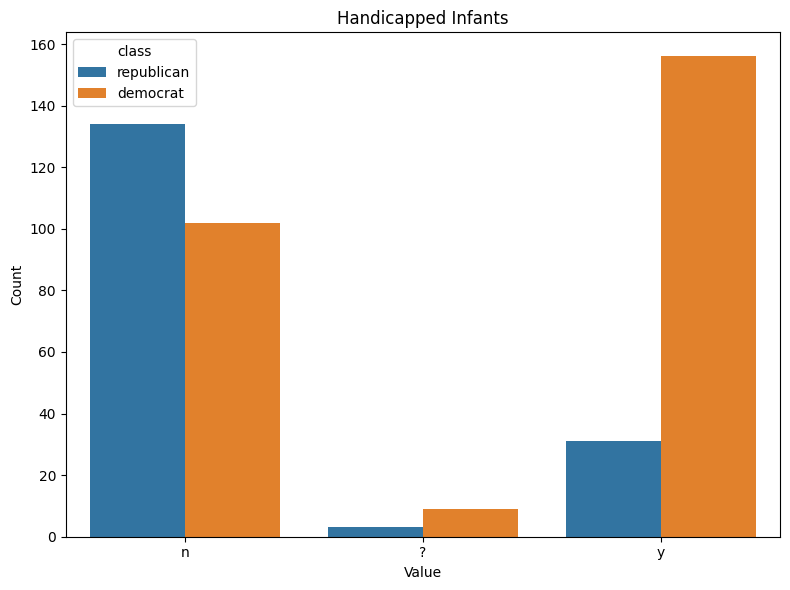

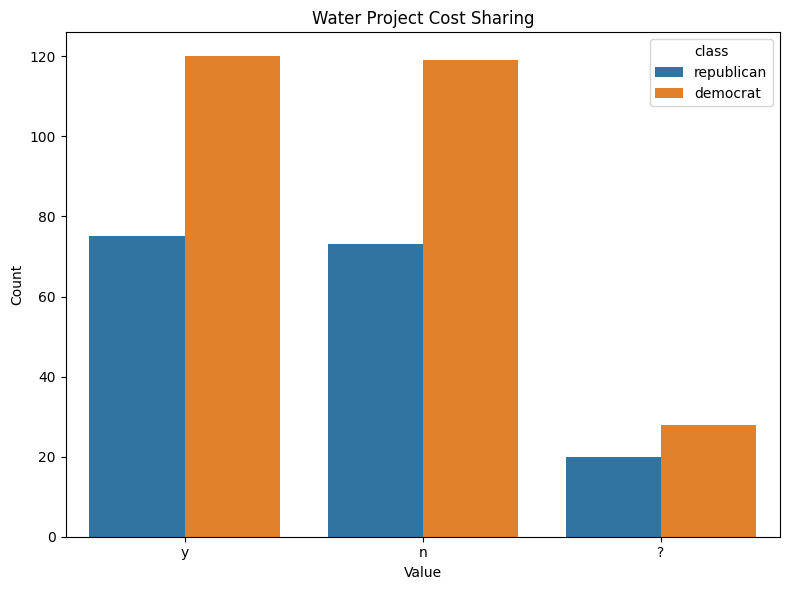

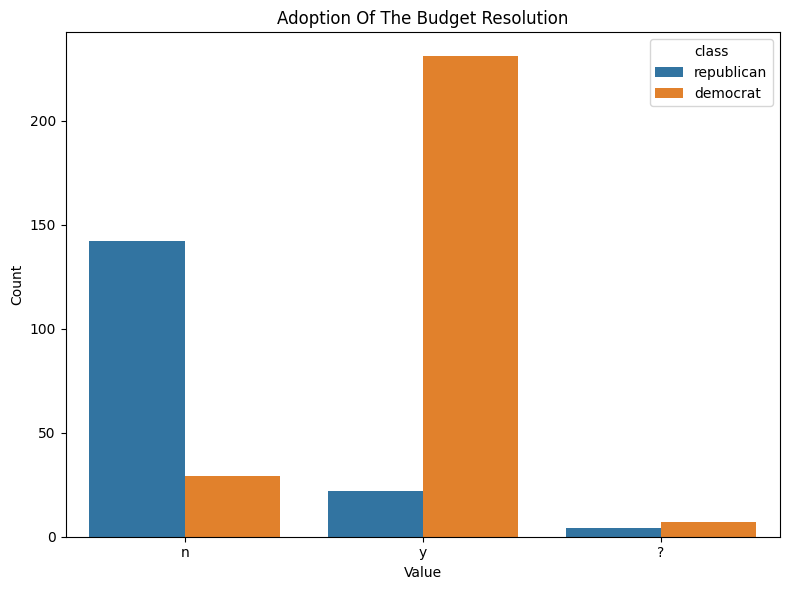

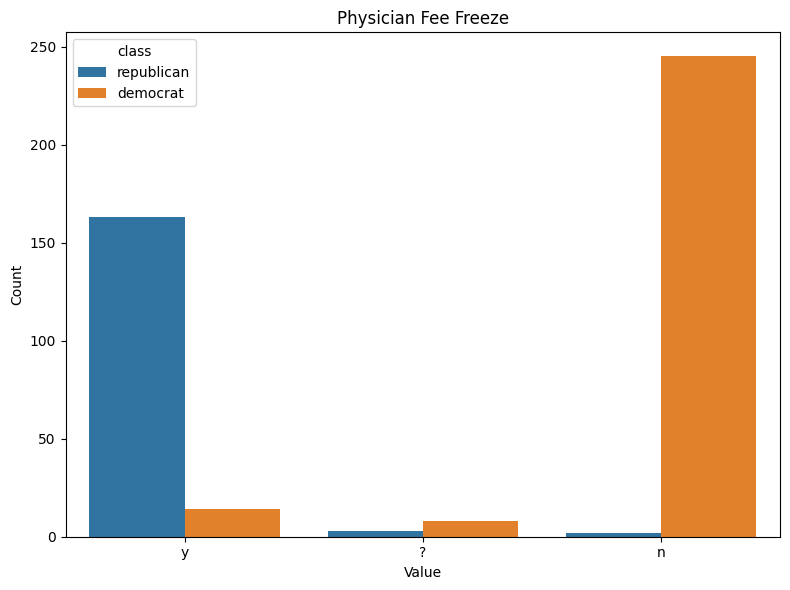

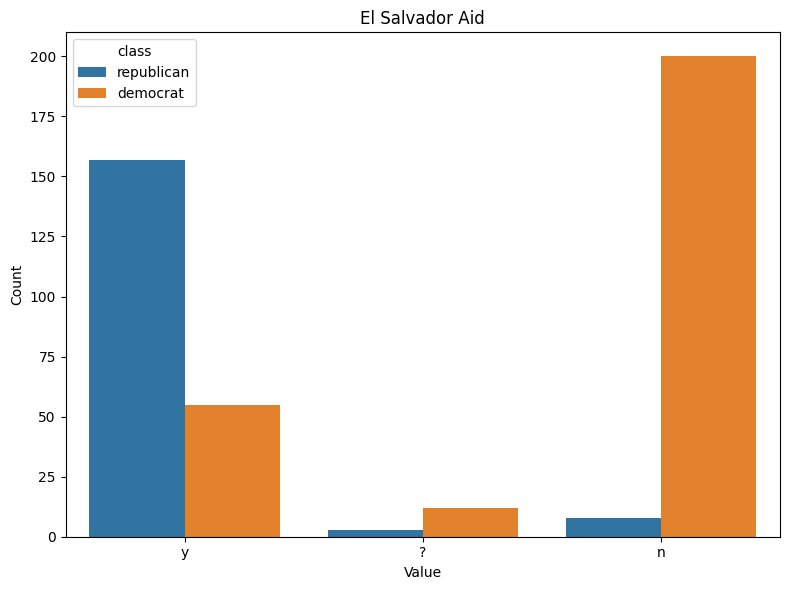

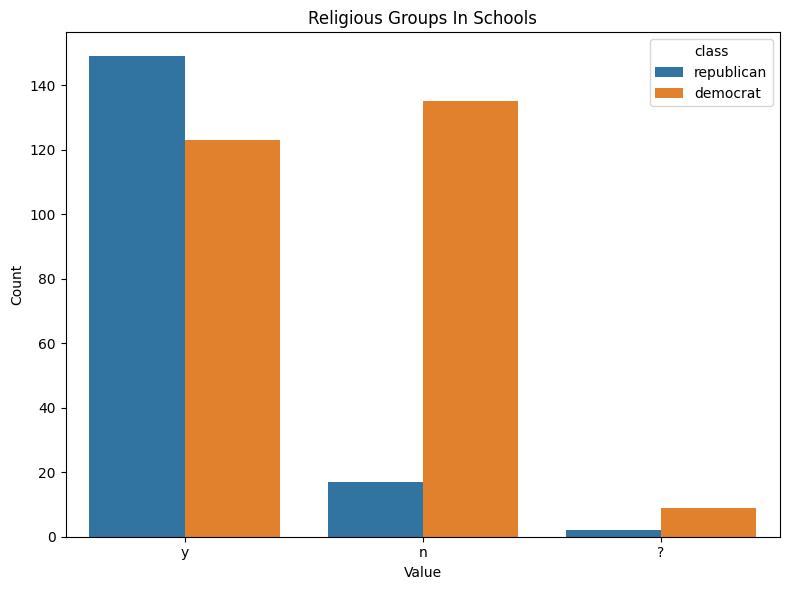

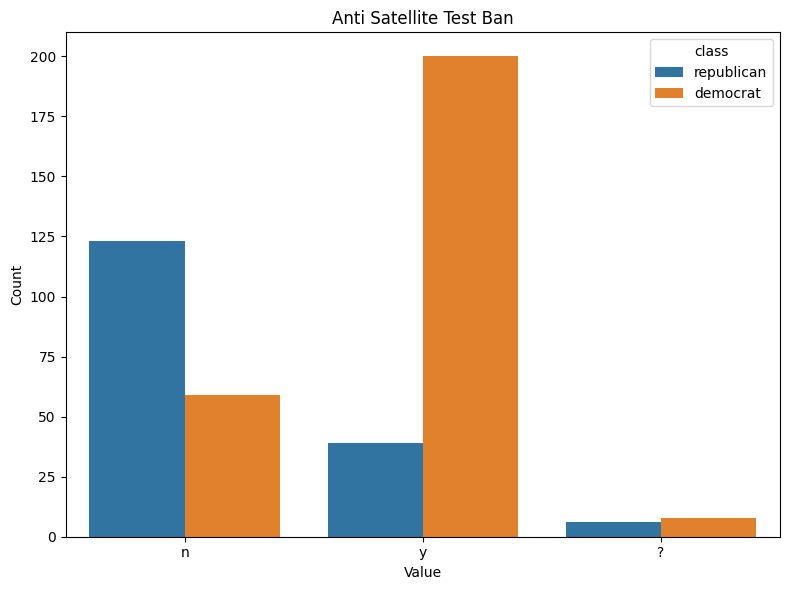

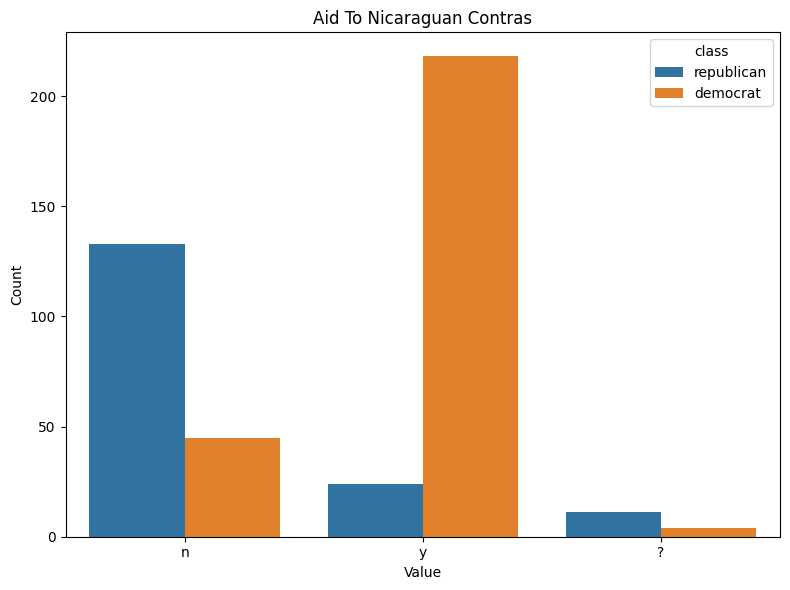

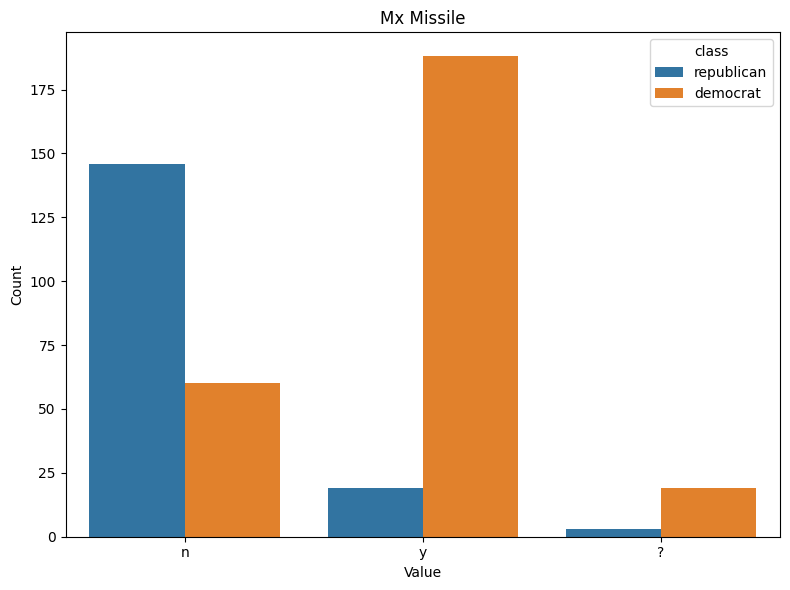

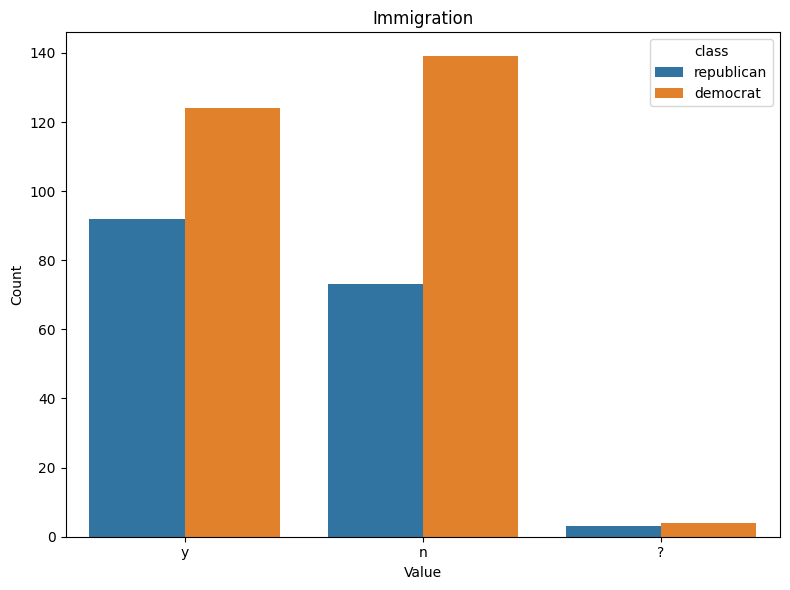

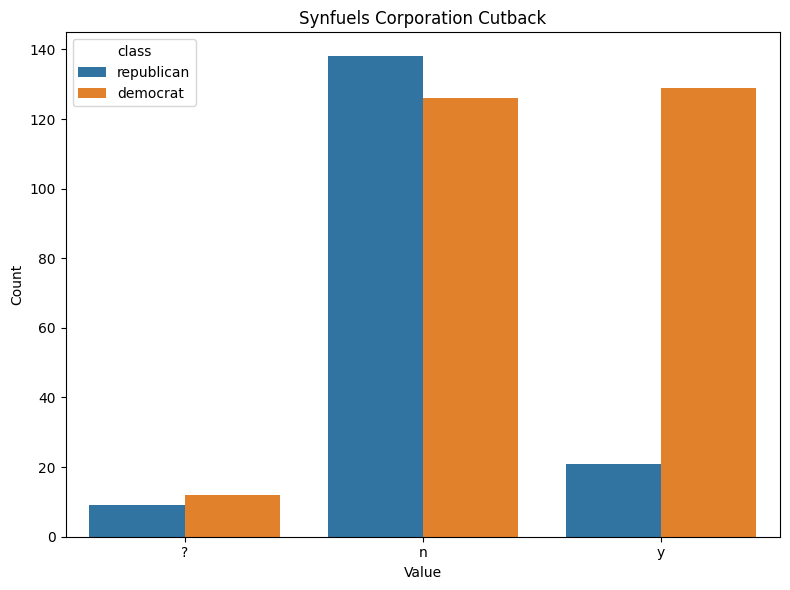

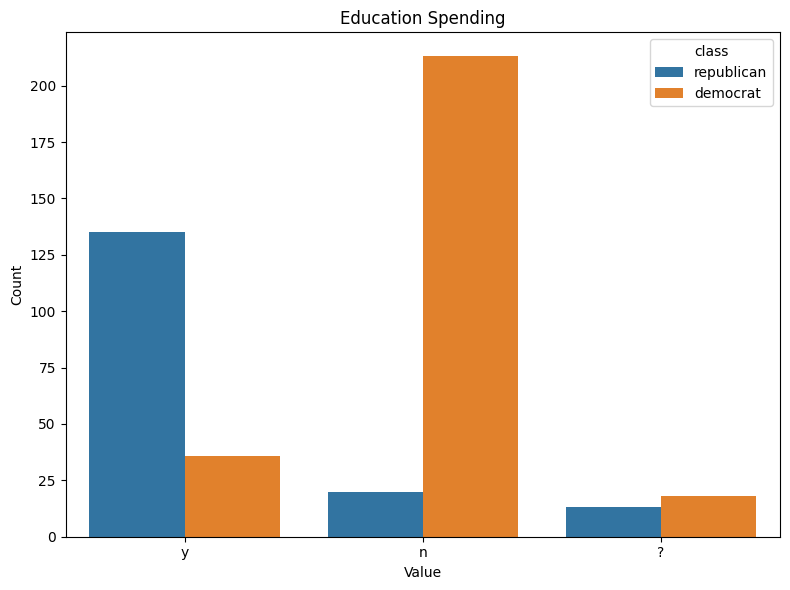

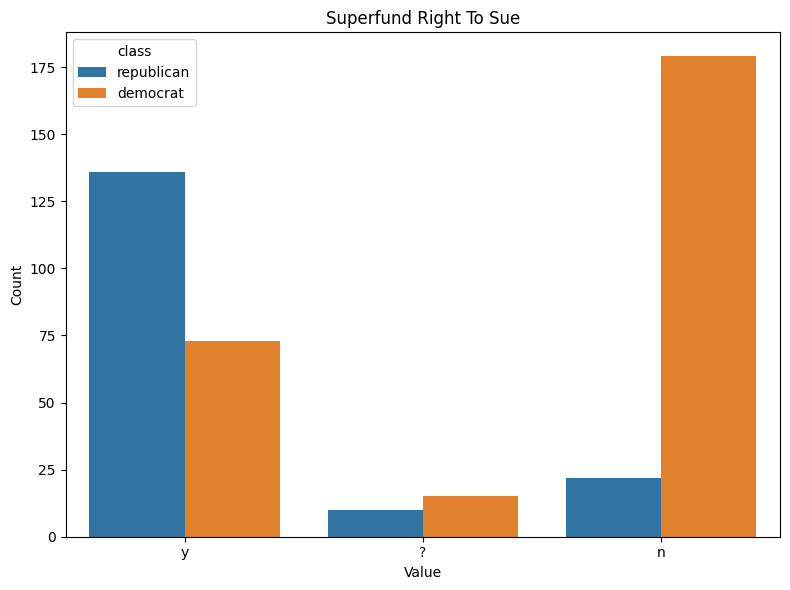

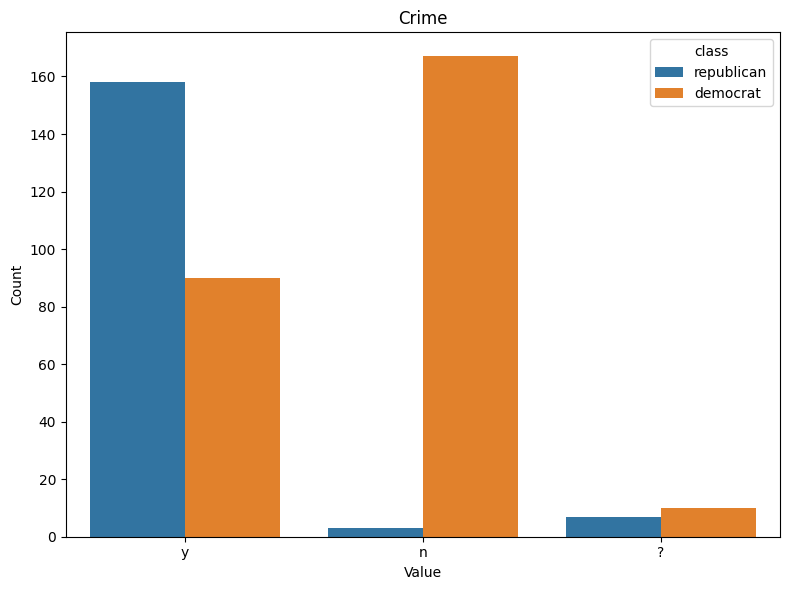

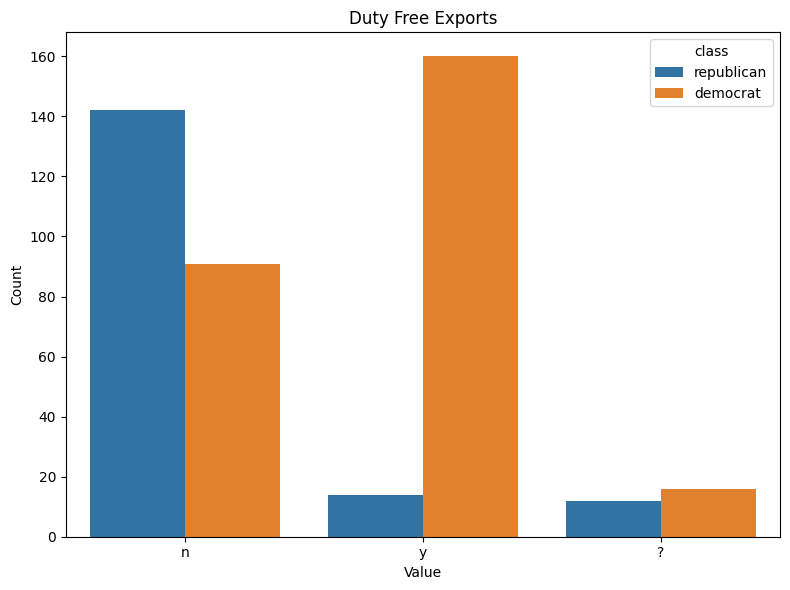

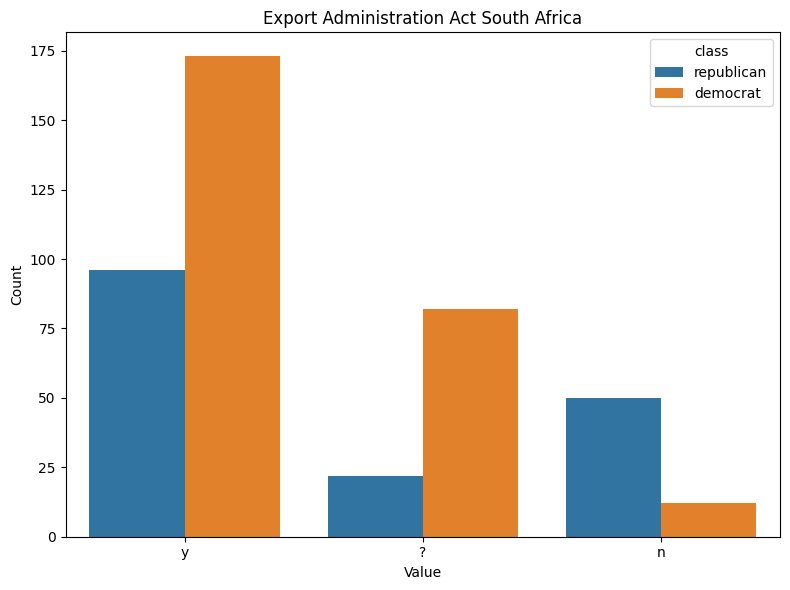

In [35]:
visualize_categorical_data(df, target_column=target_feature, show_plot=True, save_plots=False)

Replace missing values marked as '?' with NaN

In [36]:
df = df.replace('?', pd.NA)

Forward fill missing values (propagate previous values forward)

In [37]:
df = df.ffill(axis=0)

Shuffle the dataframe and split it into training and test sets<br>
70% of the data is used for training, and 30% for testing

In [38]:
train, test = np.split(df.sample(frac=1, random_state=42), [int(0.7 * len(df))])

c:\Users\Oleksa\Desktop\IAD-labs\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Convert the split data back into DataFrames with the original columns

In [39]:
train = pd.DataFrame(train, columns=cols)
test = pd.DataFrame(test, columns=cols)

Initialize the Naive Bayes classifier

In [40]:
model = NaiveBayes()

Fit the model on the training data

In [41]:
model.fit(train, target_feature)

Separate the test dataframe into features and target

In [42]:
X_test, y_test = separate_dataset(test, target_feature)

Predict the target values for the test features

In [43]:
y_predictions = model.predict(X_test)

Print the classification report showing precision, recall, f1-score, and support

In [44]:
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

    democrat       0.95      0.87      0.91        79
  republican       0.83      0.92      0.87        52

    accuracy                           0.89       131
   macro avg       0.89      0.90      0.89       131
weighted avg       0.90      0.89      0.89       131

